# Analyzing the result of the model error experiment

In [237]:
import warnings
warnings.filterwarnings('ignore') 

import os
import json

path = '../../dgym-data/analysis/noise/selection_noise'
files = [
    f'{path}/{file}' for file in os.listdir(path)
    if file.endswith('.json')
]

In [116]:
from tqdm.auto import tqdm

records = []
for file in tqdm(files):
    
    try:
        result = json.load(open(file, 'r'))
    except:
        continue
    result = result[0] if isinstance(result, list) else result
    
    cost = len(pd.DataFrame(result['annotations']).reindex(columns=['Step Tested']).dropna())
    record = {'sigma': result['sigma'], 'cost': cost}

    if 'outcome' in result.keys():
        record.update({'outcome': result['outcome']})
        records.append(record)
    else:
        record.update({'outcome': 0})
        records.append(record)
        
records = pd.DataFrame(records)

  0%|          | 0/1050 [00:00<?, ?it/s]

<Axes: xlabel='cost', ylabel='outcome'>

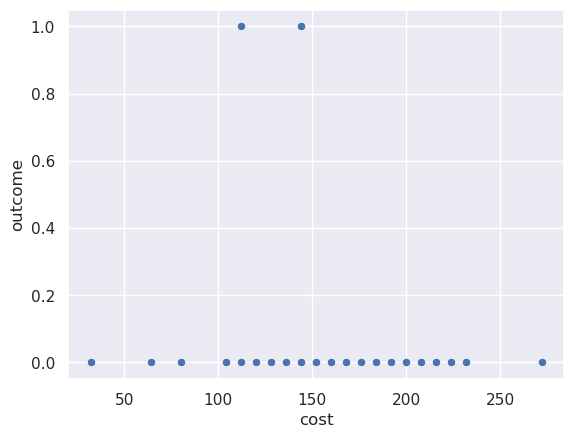

In [144]:
sns.scatterplot(
    records.query('sigma == 2.0'),
    x='cost', y='outcome',
)

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='sigma', ylabel='outcome'>

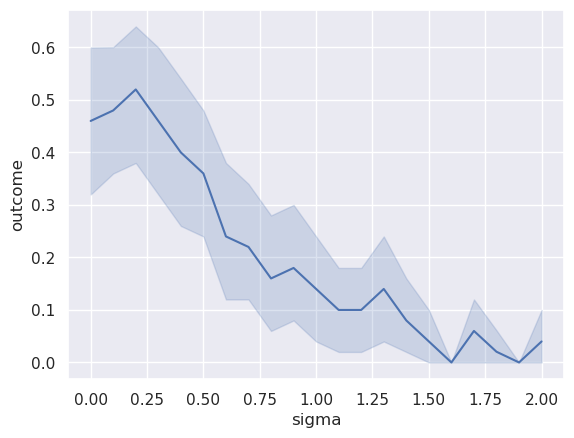

In [150]:
sns.lineplot(records, x='sigma', y='outcome')

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='sigma', ylabel='outcome'>

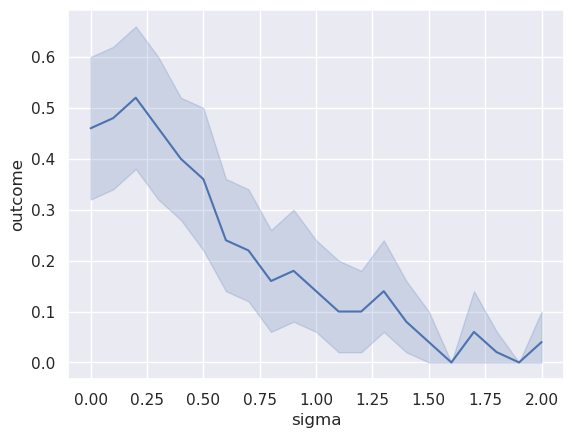

In [98]:
import seaborn as sns

sns.set()
sns.lineplot(records, x='sigma', y='outcome')

In [391]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Determine the maximum cost to extend the eCDF
max_cost = records['cost'].max()
timeline = np.linspace(0, max_cost, 3_000)

ecdfs = []
for idx, (sigma, group) in enumerate(records.groupby('sigma')):
    
    # if idx % 4 == 0:

    # Create Kaplan-Meier object
    kmf = KaplanMeierFitter()

    # Fit data
    kmf.fit(durations=group['cost'], event_observed=group['outcome'], timeline=timeline)
    ecdf = pd.merge(
        kmf.cumulative_density_,
        right=kmf.confidence_interval_cumulative_density_,
        left_index=True,
        right_index=True
    ).reset_index()
    ecdf['sigma'] = sigma
 
    # Transform survival function to eCDF
    ecdfs.append(ecdf)

Text(0.5, 1.0, 'Cumulative probability of success versus model error ($\\sigma$)')

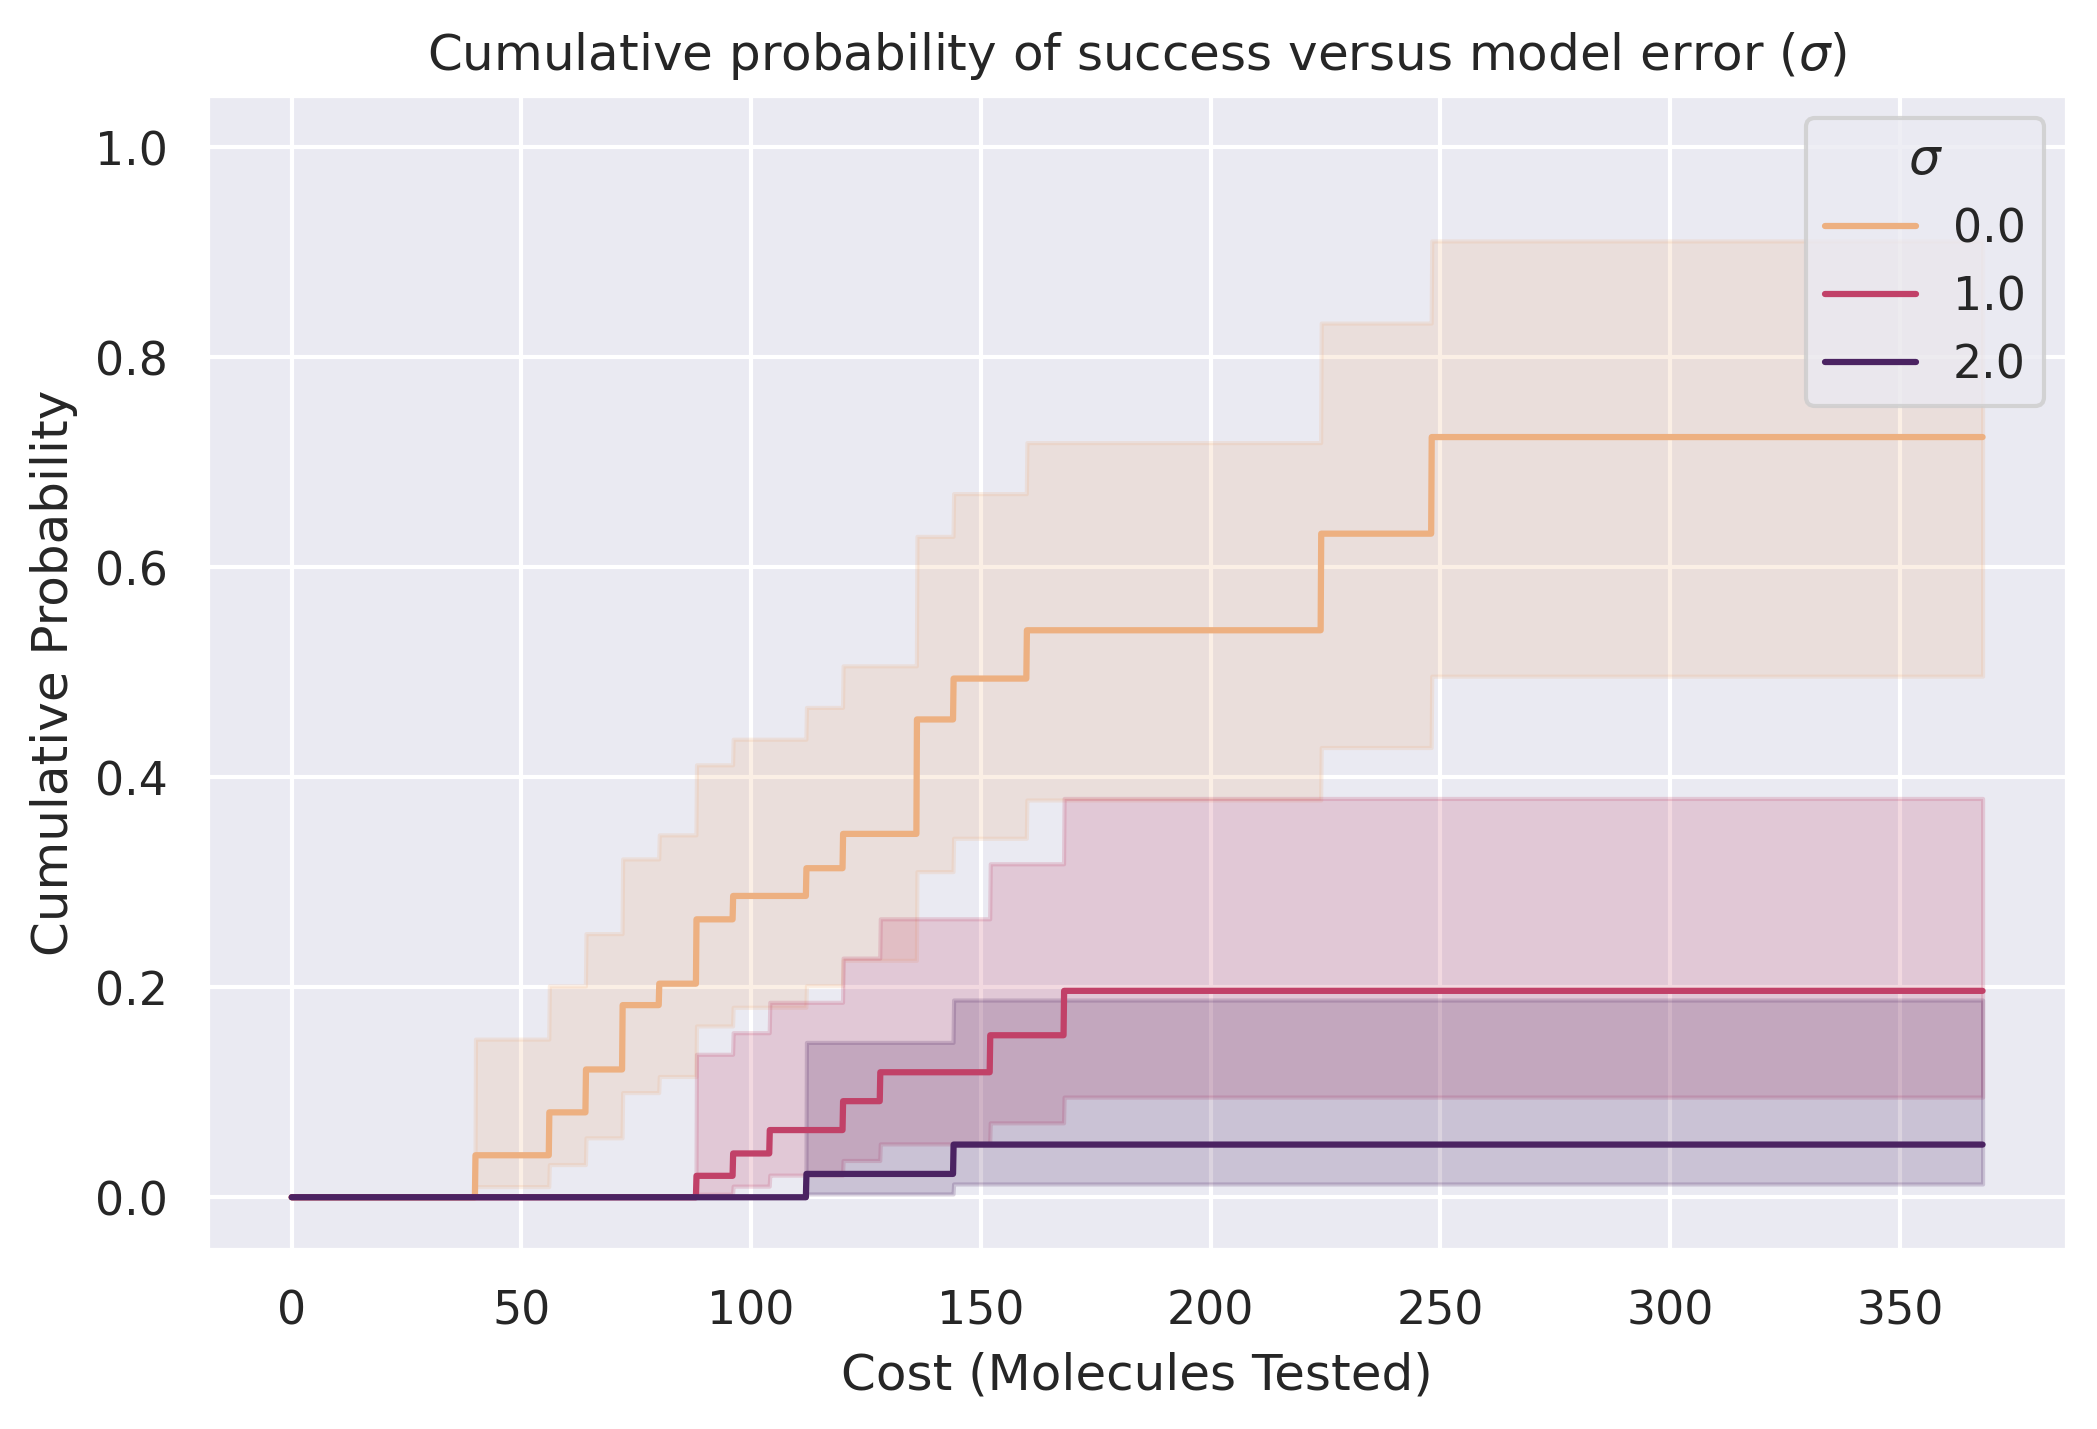

In [406]:
plt.figure(figsize=(8, 5), dpi=300)

interval = 1.0

df = pd.concat(ecdfs)
g = sns.lineplot(
    df.query(f'sigma % {interval} == 0'),
    x='timeline',
    y='KM_estimate',
    hue='sigma',
    palette='flare'
)

colormap = sns.palettes.get_colormap('flare')
colors = colormap.resampled(len(records.query(f'sigma % {interval} == 0').groupby('sigma')))

for idx, (name, group) in enumerate(df.query(f'sigma % {interval} == 0').groupby('sigma')):
    g.fill_between(
        group['timeline'],
        group['KM_estimate_lower_0.95'],
        group['KM_estimate_upper_0.95'],
        alpha=0.2,
        color=colors.colors[idx]
    )

plt.legend(title='$\sigma$')
plt.xlabel('Cost (Molecules Tested)')
plt.ylabel('Cumulative Probability')
plt.ylim(-0.05, 1.05)
plt.title('Cumulative probability of success versus model error ($\sigma$)')

Plot a single line.

Text(0.5, 1.0, 'Cumulative prob. of success versus model error ($\\sigma$) | Budget = 200 molecules')

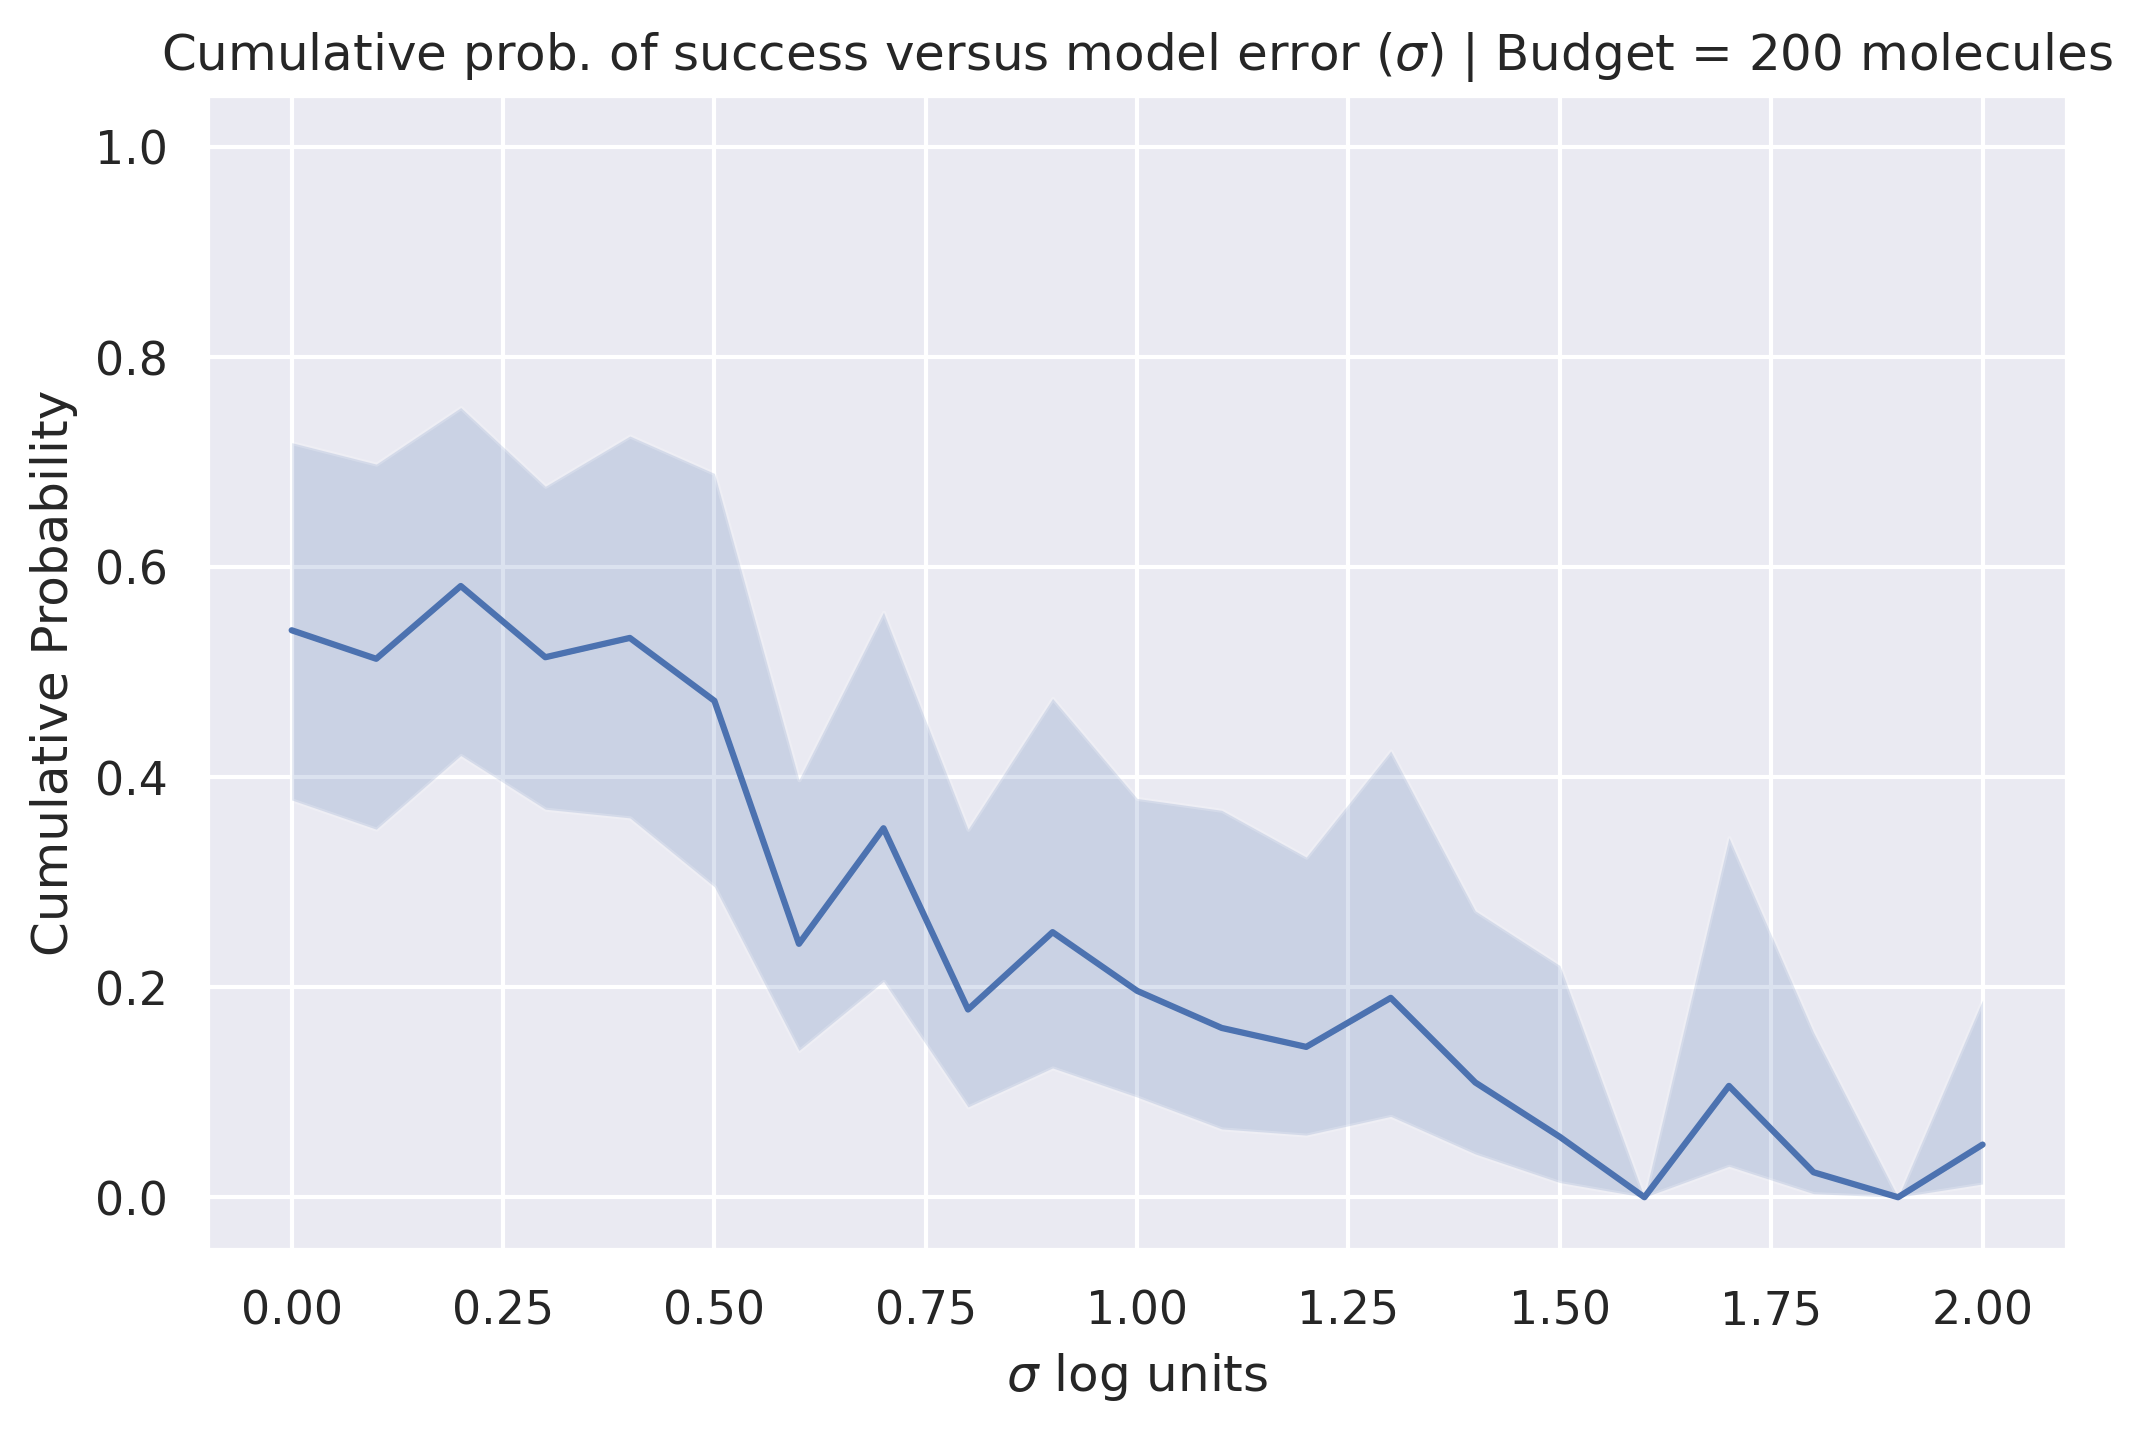

In [425]:
plt.figure(figsize=(8, 5), dpi=300)

budget = 200
filtered = df.query(f'{budget} < timeline < {budget} + 5.0')
g = sns.lineplot(
    filtered,
    x='sigma',
    y='KM_estimate',
)

g.fill_between(
    filtered['sigma'],
    filtered['KM_estimate_lower_0.95'],
    filtered['KM_estimate_upper_0.95'],
    alpha=0.2,
)

plt.ylim(-0.05, 1.05)
plt.xlabel('$\sigma$ log units')
plt.ylabel('Cumulative Probability')
plt.title(f'Cumulative prob. of success versus model error ($\sigma$) | Budget = {budget} molecules')